# Exploration of semantic data on the mesh

Here, we will
- Propose strategies to discover data on the PMD mesh, especialle when hosten using ontodocker:
    - What data is generally available?
    - What data on a specific material is available?
- Give an example for a data exploration using a distributed version of teh S355 tensile test data
    - federating queries across ontodocker instances
    - propose stategies to work with the obtained data

While doing this, we will often show a more "native" way to do things before explaining how many tasks can be simplified by useful abstactions provided in the Demonstrator Python package `pmd_demo_tools`.

## Setup

### Some basic imports:

In [1]:
%load_ext autoreload
# reload modules automatically before each cell
%autoreload 2

import requests
import os
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" # if not already set by the OS; doesn't hurt

# fixes a bug in SPARQLwrapper
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# importing pandas to make printed dataframes prettier
import pandas as pd, hashlib
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.width', 200)

`pmd_demo_tools` is a central package for the PMD Demonstrator:

In [2]:
from pmd_demo_tools import mesh_tools, sparql_tools

### Populate a local mesh-participant registry

In [6]:
# read in all servers on the mesh
partners_full = mesh_tools.mesh_namespace_grouped_by_company()

# attach hosted services
_ = mesh_tools.attach_services_in_place(partners_full)

# attach web tokens
import json
with open('../secrets/tokens.json') as f:
    tokens = json.load(f, object_hook=mesh_tools.namespace_object_hook())

partners_full.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT.iwt.services.ontodocker.token = tokens.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT.ontodocker.token
partners_full.Fraunhofer_IWM.iwm.services.ontodocker.token = tokens.Fraunhofer_IWM.ontodocker.token
partners_full.KIT.kit_3.services.ontodocker_proxy.token = tokens.KIT.ontodocker_proxy.token
partners_full.MPISusMat.mpi_susmat.services.ontodocker.token = tokens.MPISusMat.ontodocker.token

/home/jovyan/work/pmd-demonstrator/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/mesh_tools.py:606: UserWarning: Failed fetching services for glassomer.pmd.internal: 500 Server Error: Internal Server Error for url: http://mesh-listing.c.pmd.internal/api/v1/pmds/glassomer.pmd.internal.
  warnings.warn(f"Failed fetching services for {zone}: {e}.", category=UserWarning)


In case we know that were only interested in a number of companies, we can easily make a reduction of the registry:

In [7]:
selection = ["Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT", "Fraunhofer_IWM", "KIT", "MPISusMat"]
partners = mesh_tools.select_toplevel(partners_full, selection, deepcopy=True)

Please note that web tokens have to be aquired from the individual service admins. When services are configured accordingly, tokens are not needed. However, the are another means to give more access control to data owners.

## SPARQL queries
To make the following notebook easierly readable, and to make query results easierly digestible, we define some queries in `pmd_demo_tools.query_collection`.

In [8]:
from pmd_demo_tools.query_collection import S355queries
S355queries = S355queries()

You can find queries which prompt for various information, for example:
- `queries.query_materialDesignation()` For which material is data available?  
This reads out the `pmdco:value` stored under `pmdco:materialDesignation`
- `queries.query_processType()`: What process type was performed on S355?
- `queries.query_orientation()`: In what orientation relative to the rolling direction was each specimen cut?
- `queries.query_deviceAndStandard()`: Which device and standard was used for the measurements?
- `queries.query_specimen()`: What is the specimen ID
- `queries.query_csvurl()`: Under which URL can we find the csv-file?

The queries are defined as class methods. They return a dataclass instance, allowing to easily add new methods(queries) and enabling a dot notation and tab completion. They return the query (as a string), the variables uesed in the query and column headers of the JSON-ified query-result. There is also a method `sparql_tools.infer_vars_from_results()`, infering this information from the result itself.
Because a `dataclass` is used, it is very easy to make returned contents attributes directly accessible via dot-notation while reducing boilerplate code:

In [9]:
query = S355queries.material_designation()

print("query ="+query.query)
print("")
print("qvars   = "+str(query.qvars))
print("headers = "+str(query.headers))

query =
        PREFIX pmd: <https://w3id.org/pmd/co/>
        SELECT DISTINCT ?p ?matDesVal
        WHERE {
            ?s a pmd:TestPiece .
            ?p pmd:input ?s .
            ?p pmd:characteristic ?matDes .
            ?matDes a pmd:materialDesignation .
            ?matDes pmd:value ?matDesVal .
        }
        ORDER BY ?p
        

qvars   = ['p', 'matDesVal']
headers = ['uri', 'materialDesignation']


## Finding data

### Listing all SPARQL endpoints on the mesh

In [10]:
endpoints = sparql_tools.list_sparql_endpoints(partners_full)

KIT
Available SPARQL-endpoints at "ontodocker-proxy.kit-3.pmd.internal":
http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/pmdco2_tto_example_perpendicular/sparql
http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/tt_test/sparql

MPISusMat
Available SPARQL-endpoints at "ontodocker.mpi-susmat.pmd.internal":
http://ontodocker.mpi-susmat.pmd.internal/api/v1/jena/newset/sparql
http://ontodocker.mpi-susmat.pmd.internal/api/v1/jena/not4all/sparql
http://ontodocker.mpi-susmat.pmd.internal/api/v1/jena/test/sparql

Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT
Available SPARQL-endpoints at "ontodocker.iwt.pmd.internal":
https://ontodocker.iwt.pmd.internal/api/v1/jena/pmdco2_tto_example_parallel/sparql

Fraunhofer_IWM
Available SPARQL-endpoints at "ontodocker.iwm.pmd.internal":
https://ontodocker.iwm.pmd.internal/api/v1/jena/test/sparql
https://ontodocker.iwm.pmd.internal/api/v1/jena/pmdco2_tto_example_diagonal/sparql



/home/jovyan/work/pmd-demonstrator/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/sparql_tools.py:98: UserWarning: [list_sparql_endpoints] Connection error for https://ontodocker-internal.bam-s1.pmd.internal: HTTPSConnectionPool(host='ontodocker-internal.bam-s1.pmd.internal', port=443): Max retries exceeded with url: /api/v1/endpoints (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fcfe14e0810>: Failed to establish a new connection: [Errno 113] No route to host'))
  warnings.warn(f"[list_sparql_endpoints] Connection error for {base}: {e!s}", category=UserWarning)


## What datasets on the mesh have information on a material?

In [11]:
query = S355queries.material_designation()
matDes_results = sparql_tools.federated_query(partners=partners_full, query=query.query, columns=query.headers, print_to_screen=True)

Sending query to "http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/pmdco2_tto_example_perpendicular/sparql". Result:
  uri                                                      materialDesignation
0  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  S355              
1  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  S355              
2  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process  S355              
3  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process  S355              

Sending query to "http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/tt_test/sparql". Result:
Empty DataFrame
Columns: [uri, materialDesignation]
Index: []

Sending query to "http://ontodocker.mpi-susmat.pmd.internal/api/v1/jena/newset/sparql". Result:
  uri                                                       materialDesignation
0  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process  S355              
1   https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  S35

/home/jovyan/work/pmd-demonstrator/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/sparql_tools.py:195: UserWarning: [query_instance] Connection error for http://ontodocker-internal.bam-s1.pmd.internal: HTTPConnectionPool(host='ontodocker-internal.bam-s1.pmd.internal', port=80): Max retries exceeded with url: /api/v1/endpoints (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fcfe15e2f90>: Failed to establish a new connection: [Errno 113] No route to host'))
  warnings.warn(f"[query_instance] Connection error for {base}: {e!s}", category=UserWarning)


In [12]:
matDes_results_rns =mesh_tools.RecursiveNamespace(**matDes_results)

In [14]:
matDes_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result

,uri,materialDesignation
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process,S355
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-9_process,S355


Note that this method relies a query fomulated using a specific ontology. 

# Exploring information on S355 steel

## 1.) What kind of experimental information is available for S355 steel?

In [15]:
query = S355queries.process_type(material="S355") 
print(query.query)
print(query.headers)

PREFIX pmd: <https://w3id.org/pmd/co/>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        SELECT distinct ?p ?type
        WHERE {
            ?p a ?type .
            ?matDes a pmd:materialDesignation .
            ?matDes pmd:value "S355"^^xsd:string .
            ?p pmd:characteristic ?matDes .
        }
        ORDER BY ?p
['uri', 'process type']


Let's send this quers to all available SPARQL endpoints on the mesh using `sparql_tools.federated_query()`.  
*Note: You can suppress the output to screen by setting `print_to_screen=False`.*

In [16]:
S355_processes = sparql_tools.federated_query(partners=partners_full, query=query.query, columns=query.headers, print_to_screen=True)

Sending query to "http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/pmdco2_tto_example_perpendicular/sparql". Result:
  uri                                                      process type                        
0  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  https://w3id.org/pmd/co/TensileTest
1  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  https://w3id.org/pmd/co/TensileTest
2  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process  https://w3id.org/pmd/co/TensileTest
3  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process  https://w3id.org/pmd/co/TensileTest

Sending query to "http://ontodocker-proxy.kit-3.pmd.internal/api/v1/jena/tt_test/sparql". Result:
Empty DataFrame
Columns: [uri, process type]
Index: []

Sending query to "http://ontodocker.mpi-susmat.pmd.internal/api/v1/jena/newset/sparql". Result:
  uri                                                       process type                        
0  https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-

/home/jovyan/work/pmd-demonstrator/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/sparql_tools.py:195: UserWarning: [query_instance] Connection error for http://ontodocker-internal.bam-s1.pmd.internal: HTTPConnectionPool(host='ontodocker-internal.bam-s1.pmd.internal', port=80): Max retries exceeded with url: /api/v1/endpoints (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fcfe0e36850>: Failed to establish a new connection: [Errno 113] No route to host'))
  warnings.warn(f"[query_instance] Connection error for {base}: {e!s}", category=UserWarning)


### Filtering
Note the empty output for datasets which do not fit the query or when trying to contact services which are hosted on servers not connected to your intance. This can be avoided by specifying `datasets` more precisely, this that irrelevant endpoints are not queries at all. We can collect endpoints of interest from above results.

In [18]:
datasets = ["pmdco2_tto_example_parallel", "pmdco2_tto_example_perpendicular","pmdco2_tto_example_diagonal"]
S355_processes_filtered = sparql_tools.federated_query(partners=partners_full, query=query.query, columns=query.headers, datasets=datasets, print_to_screen=False)
S355_processes_filtered_rns = mesh_tools.RecursiveNamespace(**S355_processes_filtered)

Those results are `pandas.core.frame.DataFrame`s:

In [19]:
S355_processes_filtered_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,process type
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/co/TensileTest
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://w3id.org/pmd/co/TensileTest
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://w3id.org/pmd/co/TensileTest
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process,https://w3id.org/pmd/co/TensileTest


## 2.) In what orientation relative to the rolling direction was each specimen cut?

In [20]:
query = S355queries.orientation()
orientation_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
orientation_results_rns = mesh_tools.RecursiveNamespace(**orientation_results)

In [22]:
orientation_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result

,uri,cut orientation
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process,in rolling direction
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process,in rolling direction
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process,in rolling direction
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process,in rolling direction


## 3.) What devices were used for the tests and which standards were applied?

In [23]:
query = S355queries.standard_and_extensiometer()
standard_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
standard_results_rns = mesh_tools.RecursiveNamespace(**standard_results)

In [24]:
standard_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,extensiometer model,standard
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,HBM,DIN EN ISO 17025
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,HBM,DIN EN ISO 17025
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,HBM,DIN EN ISO 17025
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process,HBM,DIN EN ISO 17025


## 4.) Which ID was assigned to the specimen?

In [25]:
query = S355queries.specimen_id()
specimen_id_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
specimen_id_results_rns = mesh_tools.RecursiveNamespace(**specimen_id_results)

In [26]:
specimen_id_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,specimen id
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/testpiece_name/Zy1testpiece/Zy1
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://w3id.org/pmd/ao/tte/testpiece_name/Zy2testpiece/Zy2
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://w3id.org/pmd/ao/tte/testpiece_name/Zy3testpiece/Zy3
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process,https://w3id.org/pmd/ao/tte/testpiece_name/Zy4testpiece/Zy4


## 5) Accessing and augmenting "raw data"

### 5a.) Obtaining resource locations
For each tensile test, show the URL to the raw tesile-test data:

In [27]:
query = S355queries.csv_url()
csv_url_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
csv_url_results_rns = mesh_tools.RecursiveNamespace(**csv_url_results)

In [29]:
csv_url_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result

,uri,url
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process,https://data.mpi-susmat.pmd.internal/Zx1.csv
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process,https://data.mpi-susmat.pmd.internal/Zx2.csv
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process,https://data.mpi-susmat.pmd.internal/Zx3.csv
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process,https://data.mpi-susmat.pmd.internal/Zx4.csv


In [30]:
csv_url_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,url
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy1.csv
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy2.csv
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy3.csv
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy4.csv


In [31]:
#csv_url_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result

### 5b.) Augmentation of raw data
Show the content of the csv columns (i.e. the quantitiy and its unit) and relate it ti URI und file URL (resource location):

In [32]:
query = S355queries.csv_columns()
csv_columns_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
csv_columns_results_rns = mesh_tools.RecursiveNamespace(**csv_columns_results)

In [33]:
csv_columns_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,url,name,column number,quantity,unit
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy1.csv,b0,1,https://w3id.org/pmd/co/Duration,http://qudt.org/vocab/unit/SEC
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy1.csv,b1,2,https://w3id.org/pmd/co/CrossheadSeparation,http://qudt.org/vocab/unit/MilliM
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy1.csv,b2,3,https://w3id.org/pmd/co/Force,http://qudt.org/vocab/unit/KiloN
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy1.csv,b3,4,https://w3id.org/pmd/co/PercentageExtension,http://qudt.org/vocab/unit/PERCENT
4,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy2.csv,b4,1,https://w3id.org/pmd/co/Duration,http://qudt.org/vocab/unit/SEC
5,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy2.csv,b5,2,https://w3id.org/pmd/co/CrossheadSeparation,http://qudt.org/vocab/unit/MilliM
6,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy2.csv,b6,3,https://w3id.org/pmd/co/Force,http://qudt.org/vocab/unit/KiloN
7,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy2.csv,b7,4,https://w3id.org/pmd/co/PercentageExtension,http://qudt.org/vocab/unit/PERCENT
8,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy3.csv,b8,1,https://w3id.org/pmd/co/Duration,http://qudt.org/vocab/unit/SEC
9,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://data.kit-3.pmd.internal/S355/01_primary_data/Zy3.csv,b9,2,https://w3id.org/pmd/co/CrossheadSeparation,http://qudt.org/vocab/unit/MilliM


### 5c.) Force-displacement curves
Now, we gathered all information to actually plot and interpret the tensile test data in it's "native" form via force-displacement curves by plotting them:

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

First, we store the query results of the data we're interested in simple `lists`

In [35]:
url_results_list = [csv_url_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                    csv_url_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result#,
                    #csv_url_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                   ]

columns_results_list = [csv_columns_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                        csv_columns_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result#,
                        #csv_columns_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                       ]
rolling_direction_results_list =[orientation_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                                 orientation_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result#,
                                 #orientation_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                                ]

In the following, we try to extract as much information as possible from the semantics we collected beforehand. Still we need, some prior knowledge:
- ontologies used for the description to define prefixes for terms for quantities "force" (pmdco) or "MilliM" (qudt)
- the "terms" we're interested in

In [36]:
pmd_prefix = "https://w3id.org/pmd/co/"
displacement_term = "CrossheadSeparation"
displacement_expression = pmd_prefix+displacement_term
force_term = "Force"
force_expression = pmd_prefix+force_term


unit_prefix = "http://qudt.org/vocab/unit/"
displacement_unit_expected = "http://qudt.org/vocab/unit/MilliM"
force_unit_expected = "http://qudt.org/vocab/unit/KiloN"

Information like the names of columns of query-results can be extracted from the `SPARQLquery` instances we used to perform the queries: 

In [37]:
S355queries.orientation().headers

['uri', 'cut orientation']

In [38]:
S355queries.csv_url().headers

['uri', 'url']

In [39]:
S355queries.csv_columns().headers

['uri', 'url', 'name', 'column number', 'quantity', 'unit']

In [40]:
test_uri = "https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process"
uri_term = S355queries.csv_columns().headers[0]
unit_term = S355queries.csv_columns().headers[5]
csv_columns_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result.query(f"{uri_term} == @test_uri")[unit_term]

8         http://qudt.org/vocab/unit/SEC
9      http://qudt.org/vocab/unit/MilliM
10      http://qudt.org/vocab/unit/KiloN
11    http://qudt.org/vocab/unit/PERCENT
Name: unit, dtype: object

The following cell demonstrates how semantics enable lagely interoperable data-digestion routines:
- we have stored all results in `pandas` `DataFrames`. By obtaining the dataframes column-header directly from the query it was generated from, we can access the information stored in the column:
    - `column_results[S355queries.csv_columns().headers[0]]` gives a list of uris, over which we can iterate
    - `column_results[S355queries.csv_columns().headers[1]]` gives a list of urls, over which we can iterate
    - `column_results[S355queries.csv_columns().headers[4]]` gives a list of all column quantities
- we can relate the uri with the url and by combining knowledge about the uri with the quantitiy we're interested in, we can deduce the relevant column number in the csv
- we check units of force and displacement for consistency. Here, also a conversion step could easily be implemented.
- The only aspect specific to the used ontology is the Query itself. As long as the result

In [41]:
uri_term = S355queries.csv_columns().headers[0]
url_term = S355queries.csv_columns().headers[1]
id_term = S355queries.csv_columns().headers[2]
column_number_term = S355queries.csv_columns().headers[3]
quantity_term = S355queries.csv_columns().headers[4]
unit_term = S355queries.csv_columns().headers[5]

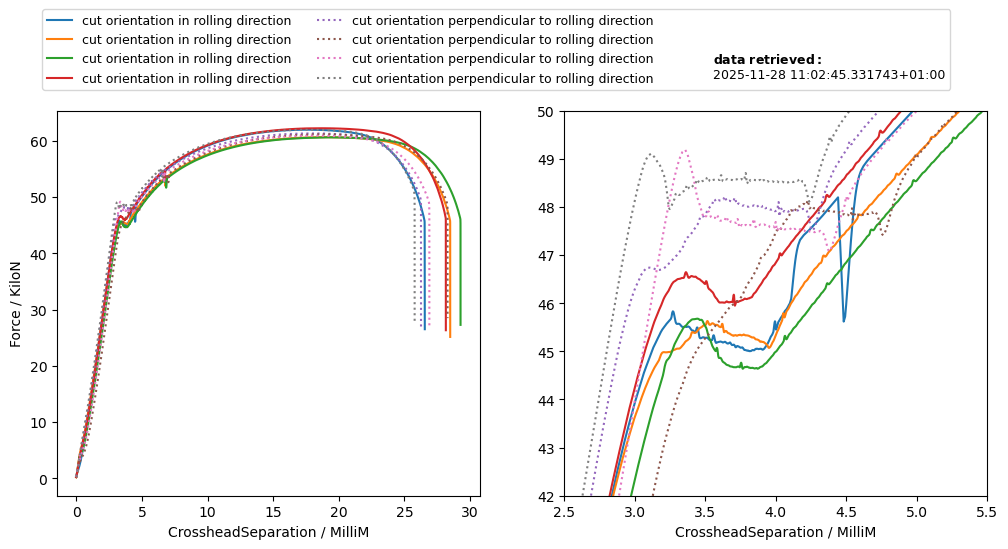

In [42]:
fig_fd, ax_fd = plt.subplots(1,2, figsize=(12,5))
linestyles =("solid", "dotted", "dashed")
for url_results, columns_results, roll_dir_results, linestyle in zip(url_results_list, columns_results_list, rolling_direction_results_list, linestyles):
    for url, uri in zip(url_results[S355queries.csv_url().headers[1]], url_results[S355queries.csv_url().headers[0]]):

        # check displacement unit consistency
        displacement_unit = columns_results.query(f"{uri_term} == @uri and {quantity_term} == @displacement_expression")[unit_term].values[0]
        if not displacement_unit == displacement_unit_expected:
            warnings.warn("Inconsistent displacement units detected!", category=UserWarning)
            # conversion ...

        # assign displacement column number
        displacement_column_number = int(columns_results.query(f"{uri_term} == @uri and {quantity_term} == @displacement_expression")[column_number_term].values[0])-1

        # check force unit consistency
        force_unit = columns_results.query(f"{uri_term} == @uri and {quantity_term} == @force_expression")[unit_term].values[0]
        if not force_unit == force_unit_expected:
            warnings.warn("Inconsistent force units detected!", category=UserWarning)
            # conversion ...

        # assign force column number
        force_column_number = int(columns_results.query(f"{uri_term} == @uri and {quantity_term} == @force_expression")[column_number_term].values[0])-1

        #roll_dir = roll_dir_results.loc[roll_dir_mask, S355queries.orientation().headers[1]].iloc[0]
        roll_dir = roll_dir_results.query(f"{uri_term} == @uri")[S355queries.orientation().headers[1]].values[0]
        
        # read csv from ressource location
        csv = pd.read_csv(url, delimiter=";", decimal=",", on_bad_lines='skip', skiprows=[1])
        
        ax_fd[0].plot(csv.iloc[:, displacement_column_number], csv.iloc[:, force_column_number], linestyle=linestyle, label=f"cut orientation {roll_dir}")
        ax_fd[1].plot(csv.iloc[:, displacement_column_number], csv.iloc[:, force_column_number], linestyle=linestyle, label=f"cut orientation {roll_dir}")

ax_fd[0].set_xlabel(displacement_term+" / "+displacement_unit.replace(unit_prefix, ""))
ax_fd[1].set_xlabel(ax_fd[0].get_xlabel())
ax_fd[0].set_ylabel(force_term+" / "+force_unit.replace(unit_prefix, ""))



#dummy plot to adjust legend & to place timestamp
ax_fd[0].plot(0,0,ls="None", c="None", label=" ")
ax_fd[0].plot(0,0,ls="None", c="None", label=" ")

timestamp = pd.Timestamp.now(tz="Europe/Berlin")
ax_fd[0].plot(0,0,ls="None", c="None", label=r"$\bf{{data\ retrieved:}}$"+ f"\n{timestamp}")

ax_fd[1].set_xlim(left=2.5, right=5.5)
ax_fd[1].set_ylim(bottom=42., top=50.)

ax_fd[0].legend(loc="upper left", bbox_to_anchor=(-0.05, 1.28), ncol=3, fontsize=9.)
fig_fd.show()

## 6) More information: `PrimaryData`, `SecondaryData` and `MetaData`

### 6a.) `PrimaryData` - e.g. sample geometries
Data acquired before / after a process either refering to the geometry (e.g. width) of the specimen or as a register of the setup (e.g. original gauge length).

In [43]:
query = S355queries.primary_data()
primary_data_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
primary_data_results_rns = mesh_tools.RecursiveNamespace(**primary_data_results)

In [44]:
primary_data_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,quantity,value,unit
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_crossSectionArea_S0,120.679,http://qudt.org/vocab/unit/MilliM2
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_crossSectionArea_Su,56.039,http://qudt.org/vocab/unit/MilliM2
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_crossSectionArea_s1,120.774,http://qudt.org/vocab/unit/MilliM2
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_crossSectionArea_s2,120.637,http://qudt.org/vocab/unit/MilliM2
4,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_crossSectionArea_s3,120.627,http://qudt.org/vocab/unit/MilliM2
5,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_finalGaugeLengthAfterFracture_Lu,NaN,http://qudt.org/vocab/unit/MilliM
6,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_originalGaugeLength_L0,60.0,http://qudt.org/vocab/unit/MilliM
7,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_thicknessAfterFracture_au,3.82,http://qudt.org/vocab/unit/MilliM
8,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_thickness_a1,6.0,http://qudt.org/vocab/unit/MilliM
9,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_thickness_a2,5.992,http://qudt.org/vocab/unit/MilliM


In [45]:
uri_term = S355queries.primary_data().headers[0] # uri
quantity_term = S355queries.primary_data().headers[1] # quantity
value_term = S355queries.primary_data().headers[2] # value
unit_term = S355queries.primary_data().headers[3] # unit
cross_section_term = "crossSectionArea_S0"

In [46]:
test_uri = "https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process"
primary_data_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result.query(f"{uri_term} == @test_uri and `{quantity_term}`.str.contains(@cross_section_term, na=False)", engine="python")

,uri,quantity,value,unit
30,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_crossSectionArea_S0,120.663,http://qudt.org/vocab/unit/MilliM2


### 6b.) `SecondaryData` - calculated data
Characteristic values (e.g. test results) determined by equations or algorithms using primary data and metadata for a process (for example directly by the testing machine).

In [49]:
query = S355queries.secondary_data()
secondary_data_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
secondary_data_results_rns = mesh_tools.RecursiveNamespace(**secondary_data_results)

In [50]:
secondary_data_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result

,uri,quantity,value,unit
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_maximumForce,61.305,http://qudt.org/vocab/unit/kiloN
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_modulusOfElasticity,210.0,http://qudt.org/vocab/unit/GigaPa
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_percentageElongationAfterFracture,NaN,http://qudt.org/vocab/unit/PERCENT
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_percentageReductionOfArea,54.0,http://qudt.org/vocab/unit/PERCENT
4,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_proofStrength_Rp02,396.0,http://qudt.org/vocab/unit/MegaPa
5,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_tensileStrength,508.0,http://qudt.org/vocab/unit/MegaPa
6,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_upperYieldStrength,399.0,http://qudt.org/vocab/unit/MegaPa
7,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_maximumForce,61.2,http://qudt.org/vocab/unit/kiloN
8,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_modulusOfElasticity,214.0,http://qudt.org/vocab/unit/GigaPa
9,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_percentageElongationAfterFracture,35.0,http://qudt.org/vocab/unit/PERCENT


### 6c.) `MetaData` - other "external" information
Attributes and additional data concerning the factory, laboratory, the process system and the objects which allow the evaluation of the quality / reliability of the measurements and a systematic search task of a database.

In [51]:
query = S355queries.metadata()
metadata_results = sparql_tools.federated_query(partners=partners_full, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
metadata_results_rns = mesh_tools.RecursiveNamespace(**metadata_results)

In [52]:
metadata_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result

,uri,Quantity,value,unit
0,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_environmentalTemperature,20.0,http://qudt.org/vocab/unit/DEG_C
1,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_extensometerGaugeLength,50.0,http://qudt.org/vocab/unit/MilliM
2,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_transitionPoint,1.6,http://qudt.org/vocab/unit/PERCENT
3,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_environmentalTemperature,20.0,http://qudt.org/vocab/unit/DEG_C
4,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_extensometerGaugeLength,50.0,http://qudt.org/vocab/unit/MilliM
5,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_transitionPoint,3.8,http://qudt.org/vocab/unit/PERCENT
6,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_environmentalTemperature,20.0,http://qudt.org/vocab/unit/DEG_C
7,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_extensometerGaugeLength,50.0,http://qudt.org/vocab/unit/MilliM
8,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_transitionPoint,3.8,http://qudt.org/vocab/unit/PERCENT
9,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process,https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_environmentalTemperature,20.0,http://qudt.org/vocab/unit/DEG_C
